# Sentiment Classification


# Note:

I have used Tensorflow's Keras implementation rather than Keras library.

In [5]:
import tensorflow as tf
print (tf.__version__)

2.1.0


## Loading the dataset

In [7]:
from tensorflow.keras.datasets import imdb

vocab_size = 10000 #vocab size

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size) # vocab_size is no.of words to consider from the dataset, ordering based on frequency.

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab_size = 10000 #vocab size
maxlen = 300  #number of word used from each review

## Train test split

In [10]:
#load dataset as a list of ints
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

#make all sequences of the same length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test =  pad_sequences(x_test, maxlen=maxlen)

## Build Keras Embedding Layer Model
We can think of the Embedding layer as a dicionary that maps a index assigned to a word to a word vector. This layer is very flexible and can be used in a few ways:

* The embedding layer can be used at the start of a larger deep learning model. 
* Also we could load pre-train word embeddings into the embedding layer when we create our model.
* Use the embedding layer to train our own word2vec models.

The keras embedding layer doesn't require us to onehot encode our words, instead we have to give each word a unqiue intger number as an id. For the imdb dataset we've loaded this has already been done, but if this wasn't the case we could use sklearn [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [25]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

logdir = 'log'

def create_callbacks():
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=5),
        ModelCheckpoint(filepath='nlp-model.h5', monitor='val_loss', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
        TensorBoard(logdir, histogram_freq=1)
    ]
    return callbacks

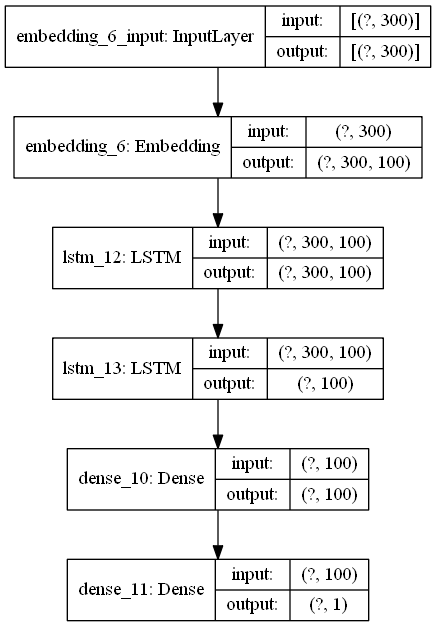

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D

def create_model():
    model = Sequential()
    
    #Embedding layer has three attributes
        # input_dim - size of the vocabulary
        # output_dim - number of dimensions in which each word is embedded
        # input_length - length of each word
    model.add(Embedding(input_dim=vocab_size,output_dim=100,input_length=maxlen))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

tf.keras.utils.plot_model(model, show_shapes=True)

In [87]:
model = create_model()
cbk = create_callbacks()



history = model.fit(x_train, 
                    y_train,
                    epochs=5, 
                    validation_split=0.1, 
                    batch_size=16, 
                    callbacks=cbk)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 300, 100)          80400     
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 1,171,001
Trainable params: 1,171,001
Non-trainable params: 0
_________________________________________________________________
Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 50s 

In [88]:
%tensorboard --logdir log

Reusing TensorBoard on port 6006 (pid 15000), started 0:34:03 ago. (Use '!kill 15000' to kill it.)

# Visualize the Training Metadata (Accuracy & Loss)

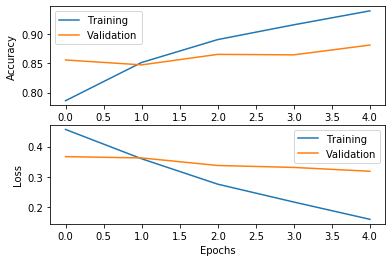

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure()

ax1 = figure.add_subplot(211)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(labels=['Training','Validation'])

ax1 = figure.add_subplot(212)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(labels=['Training','Validation'])

plt.show()

## Retrive the output of each layer in keras for a given single test sample from the trained model you built

### Do sample prediction and observe outcome

In [90]:
import numpy as np

#get sample review
sample = x_test[1]

#change the shape of review to a (1,300) shape
sample = sample.reshape(1,-1)

#get actual outcome
actual_outcome = y_test[1]

#get logits for prediction
predicted_outcome = model.predict(sample)

predicted_outcome =1 if (predicted_outcome[0][0]>0.6) else 0

print ('Expected outcome was {:} and Predicted outcome is {:}'.format(actual_outcome, predicted_outcome))

Expected outcome was 1 and Predicted outcome is 1


### Review output of each layer

In [91]:
#Create model object to capture activations/outputs from layers
from tensorflow.keras.models import Model

# Fetch the layers from the model object
layers = model.layers

print ('Number of layers in network is %d'%(len(layers)))
for i in range(0,len(layers)):
    print ('\n**********************************')
    print ('Layer name is %s'%(layers[i].name))
    
    layer_ouput = [layer.output for layer in layers[:i]]

    # Here we are defining a new type of model object; Model. This model takes the actual model as input, 
    # expected cnn layers as output and loads the outputs.
    activation_model = Model(inputs=model.input, outputs=layers[i].output)

    activations = activation_model.predict(sample)
    if (len(activations)>0) :
        print ('shape of activation is ',activations[0].shape)
    
    print ('activation is',activations)


Number of layers in network is 5

**********************************
Layer name is embedding_7
shape of activation is  (300, 100)
activation is [[[-0.08317787 -0.06397139 -0.00139001 ... -0.04810453 -0.07415926
   -0.04261355]
  [-0.08317787 -0.06397139 -0.00139001 ... -0.04810453 -0.07415926
   -0.04261355]
  [-0.08317787 -0.06397139 -0.00139001 ... -0.04810453 -0.07415926
   -0.04261355]
  ...
  [ 0.08108505  0.0594085  -0.09183964 ... -0.02841326 -0.01731722
    0.02069263]
  [-0.04900761 -0.11214229  0.04197137 ... -0.00014583  0.0092349
   -0.01309755]
  [ 0.0714838   0.03619068 -0.0034053  ...  0.03758349  0.03321303
   -0.01441377]]]

**********************************
Layer name is lstm_14
shape of activation is  (300, 100)
activation is [[[ 0.08624059  0.03584225  0.07041584 ... -0.09508853  0.00717783
   -0.02993832]
  [ 0.1290875   0.05310402  0.12236909 ... -0.1662507   0.0099768
   -0.0450757 ]
  [ 0.14788671  0.06110537  0.15841979 ... -0.21448423  0.010989
   -0.05263419